#### Since the method with so many tracers, and so many coefficients is a handful (** also it was giving funky results in some locations**) it would be useful to look at a single point in more detail, trying to understand the details of the least squares problem.

In [522]:
import numpy as np
import xarray as xr
from funcs import *
%matplotlib widget
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors, ticker, cm
from matplotlib.colors import LogNorm

In [523]:
Lcoarse = 50e3

In [524]:
Trac_coarse = xr.open_dataset('./outputs_ncfiles/Trac_coarse_'+str(int(Lcoarse//1e3))+'km')
Vels_coarse = xr.open_dataset('./outputs_ncfiles/Vels_coarse_'+str(int(Lcoarse//1e3))+'km')

In [574]:
T_coarse    = xr.open_dataset('./outputs_ncfiles/T_coarse_'+str(int(Lcoarse//1e3))+'km')

In [553]:
diff_tensor = xr.open_dataset('./outputs_ncfiles/diff_tensor_'+str(int(Lcoarse//1e3))+'km.nc')
diff_tensor_withKPP = xr.open_dataset('./outputs_ncfiles/diff_tensor_with_diff_'+str(int(Lcoarse//1e3))+'km.nc')


In [525]:
list_trac = ['TRAC01', 'TRAC02', 'TRAC03', 'TRAC04', 'TRAC05', 
            'TRAC06', 'TRAC07', 'TRAC08', 'TRAC09', 'TRAC10', 
            'TRAC11', 'TRAC12', 'TRAC13', 'TRAC14', 'TRAC15', 
            'TRAC16', 'TRAC17', 'TRAC18', 'TRAC19', 'TRAC20']

In [526]:
[UpCp, VpCp, WpCp] = get_flux_arrays(Trac_coarse, list_trac)
[dCdx, dCdy, dCdz]= get_grad_arrays(Trac_coarse, list_trac)

One location that is weird 
.sel(Z=-300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest')

It is useful to realize that the least square problem for the full tensor is a collection of 3 independent problems. 

So for in the X direction

In [102]:
xloc= 1700e3
yloc = 1000e3
zloc =-300

In [599]:
# buoyancy variables 
yub = T_coarse.UpTp.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest')
yvb = T_coarse.VpTp.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest')
ywb = T_coarse.WpTp.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest')

E1b = T_coarse.T_X.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest')
E2b = T_coarse.T_Y.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest')
E3b = T_coarse.T_Z.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest')

In [447]:
# fast variables
yufast= UpCp.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(1,19,2))
yvfast= VpCp.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(1,19,2))
ywfast= WpCp.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(1,19,2))
# the number in front of E is the column number 
E1fast = dCdx.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(1,19,2))
E2fast = dCdy.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(1,19,2))
E3fast = dCdz.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(1,19,2))

Efast = np.stack((E1fast.data, E2fast.data, E3fast.data), axis=1)

In [448]:
# slow variables
yuslow= UpCp.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(2,20,2))
yvslow= VpCp.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(2,20,2))
ywslow= WpCp.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(2,20,2))
# the number in front of E is the column number 
E1slow = dCdx.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(2,20,2))
E2slow = dCdy.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(2,20,2))
E3slow = dCdz.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(2,20,2))

Eslow = np.stack((E1slow.data, E2slow.data, E3slow.data), axis=1)

In [348]:
# As 3 - 1D problems? 
#[xu, ru, rank, s]  = np.linalg.lstsq(-E, yu)
#[xv, rv, rank, s]  = np.linalg.lstsq(-E, yv)
#[xw, rw, rank, s]  = np.linalg.lstsq(-E, yw)

xu = pinv(-E).dot(yu)
xv = pinv(-E).dot(yv)
xw = pinv(-E).dot(yw)

In [349]:
Fu = -E.dot(xu)
Fv = -E.dot(xv)
Fw = -E.dot(xw)

In [350]:
Eu = np.abs(Fu - yu.data)/np.abs(yu)
Ev = np.abs(Fv - yv.data)/np.abs(yv)
Ew = np.abs(Fw - yw.data)/np.abs(yw)

In [647]:
# Weighted 
W = np.abs(yu.values)
#[xuw, ruw, rank, s]  = np.linalg.lstsq(-E/W[:,None], yu/W)
xuw = pinv(-E/W[:,None]).dot(yu/W)
W = np.abs(yv.values)
#[xvw, rvw, rank, s]  = np.linalg.lstsq(-E/W[:,None], yv/W)
xvw = pinv(-E/W[:,None]).dot(yv/W)
W = np.abs(yw.values)
#[xww, rww, rank, s]  = np.linalg.lstsq(-E/W[:,None], yw/W)
xww = pinv(-E/W[:,None]).dot(yw/W)

In [648]:
Fuw = -E.dot(xuw)
Fvw = -E.dot(xvw)
Fww = -E.dot(xww)

Euw = np.abs(Fuw - yu.data)/np.abs(yu)
Evw = np.abs(Fvw - yv.data)/np.abs(yv)
Eww = np.abs(Fww - yw.data)/np.abs(yw)

In [353]:
idx = np.argsort(np.abs(yu.values))
idy = np.argsort(np.abs(yv.values))
idz = np.argsort(np.abs(yw.values))

In [354]:
# As a single 3D problem
# but pinverse actually solved 3 stacked problems individually!! 

F = np.stack((yu.data, yv.data, yw.data), axis=0)
G = E.T

K = -F.dot(pinv(G))

In [355]:
F3 = -K.dot(G)

E3 = np.abs(F3 - F)/np.abs(F)

IndexError: too many indices

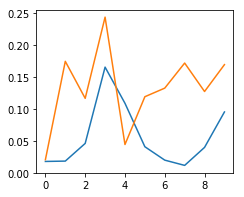

In [649]:
plt.figure(figsize=(12,3))
plt.subplot(131)
plt.plot(Eu[idx])
plt.plot(Euw[idx])
plt.plot(E3[0,idx])
plt.title('X')
plt.ylim([0,1])

plt.subplot(132)
plt.plot(Ev[idy])
plt.plot(Evw[idy])
plt.plot(E3[1,idy])
plt.title('Y')
plt.ylim([0,1])

plt.subplot(133)
plt.plot(Ew[idz], label='Unweighted')
plt.plot(Eww[idz], label='Weighted')
plt.plot(E3[2,idz], label= '3D Unweighted')
plt.title('Z')
plt.ylim([0,1])

plt.legend()

# There are two ways to proceed - 
a) Either solve 3 stacked problems with weighting. Here flux in each direction gets its own flux. 

b) Solve a vector problem. 

In [ ]:
# The solving 3 problem way. 

In [743]:
# this does the same thing as the old calc tensor; solves stacked problem,
# but does weighting but the amount of flux.
def calc_tensor_3(uc,vc,wc, cx,cy,cz):
    Afluxu = np.array([uc]).T
    Afluxv = np.array([vc]).T
    Afluxw = np.array([wc]).T
    
    Wu = np.abs(Afluxu)
    Wv = np.abs(Afluxv)
    Ww = np.abs(Afluxw)
    
    Agrad = np.array([cx, cy, cz]).T

    if ~(np.isnan(Agrad).any() |  np.isnan(Afluxu).any() |  np.isnan(Afluxv).any() |  np.isnan(Afluxw).any()):
        
        Kx = pinv(-Agrad/Wu).dot(Afluxu/Wu)
        Ky = pinv(-Agrad/Wv).dot(Afluxv/Wv)
        Kz = pinv(-Agrad/Ww).dot(Afluxw/Ww)
    
        K = np.concatenate((Kx.T, Ky.T, Kz.T), axis=0)
        
        # return(K, Kx)
        return K
    else:
        return np.NaN*np.ones((3,3), dtype='float32')

In [692]:
[Kfast, Kxfast] = calc_tensor_3(yufast, yvfast, ywfast, E1fast, E2fast, E3fast)
[Kslow, Kxslow] = calc_tensor_3(yuslow, yvslow, ywslow, E1slow, E2slow, E3slow)

In [693]:
Kfast_noweight = calc_tensor(yufast, yvfast, ywfast, E1fast, E2fast, E3fast)
Kslow_noweight = calc_tensor(yuslow, yvslow, ywslow, E1slow, E2slow, E3slow)

In [694]:
Kfast_noweight

array([[ 1.4372177e+04, -4.7870781e+03, -4.5577191e-02],
       [-3.8371553e+03,  1.3263856e+03, -1.0687878e+00],
       [-2.4810076e-01, -3.5962954e+00,  1.9844924e-03]], dtype=float32)

In [695]:
Kslow_noweight

array([[ 1.3394782e+04, -5.5659121e+03,  7.3626503e-02],
       [-3.2710190e+03, -1.1364866e+02, -1.1387548e+00],
       [-7.7101904e-01, -3.8588357e+00,  2.0312599e-03]], dtype=float32)

In [696]:
Kfast

array([[ 1.20344795e+04, -5.05143994e+03,  1.81427002e-02],
       [-2.64512354e+03,  5.94881836e+02, -1.15748978e+00],
       [-2.06247240e-01, -3.05485415e+00,  1.94045156e-03]], dtype=float32)

In [697]:
Kslow

array([[ 1.2902995e+04, -5.8457866e+03,  2.6337433e-01],
       [-4.0320117e+03, -1.2226068e+03, -4.0885162e-01],
       [-3.9390141e-01, -3.2064562e+00,  1.7228276e-03]], dtype=float32)

In [515]:
lam1 = 1/31104000.
lam2 = 1/186624000.

Kcorr = (lam2*Kfast - lam1*Kslow)/(lam2 - lam1)
Kcorr_noweight = (lam2*Kfast_noweight - lam1*Kslow_noweight)/(lam2 - lam1)

In [518]:
Kcorr_noweight

array([[ 1.3199303e+04, -5.7216787e+03,  9.7467236e-02],
       [-3.1577917e+03, -4.0165552e+02, -1.1527482e+00],
       [-8.7560266e-01, -3.9113433e+00,  2.0406132e-03]], dtype=float32)

In [528]:
diff_tensor.Kcorr.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest')
# ok seems like the rewritten bits to work at one point are working well 

<xarray.DataArray 'Kcorr' (i: 3, j: 3)>
array([[ 1.319930e+04, -5.721679e+03,  9.746724e-02],
       [-3.157792e+03, -4.016555e+02, -1.152748e+00],
       [-8.756027e-01, -3.911343e+00,  2.040613e-03]], dtype=float32)
Coordinates:
    Z            float32 -327.0
    YCcoarse     float32 1025000.0
    XCcoarse     float32 1725000.0
    hFacCcoarse  float32 ...
    PHrefC       float32 ...
    drF          float32 ...
Dimensions without coordinates: i, j

In [496]:
def calc_err(uc,vc,wc,cx,cy,cz,K):
    rU = - (K[0,0]*cx + K[0,1]*cy + K[0,2]*cz)
    rV = - (K[1,0]*cx + K[1,1]*cy + K[1,2]*cz)
    rW = - (K[2,0]*cx + K[2,1]*cy + K[2,2]*cz)    
    
    eU = np.abs(uc - rU)/np.abs(uc)
    eV = np.abs(vc - rV)/np.abs(vc)
    eW = np.abs(wc - rW)/np.abs(wc)
    
    return rU, rV, rW, eU, eV, eW

In [501]:
[rUfast, rVfast, rWfast, eUfast, eVfast, eWfast] = calc_err(yufast, yvfast, ywfast, E1fast, E2fast, E3fast,Kfast)
[rUslow, rVslow, rWslow, eUslow, eVslow, eWslow] = calc_err(yuslow, yvslow, ywslow, E1slow, E2slow, E3slow,Kslow)

In [536]:
[rUfast_noweight, rVfast_noweight, rWfast_noweight, eUfast_noweight, eVfast_noweight, eWfast_noweight] = calc_err(
    yufast, yvfast, ywfast, E1fast, E2fast, E3fast,Kfast_noweight)

[rUslow_noweight, rVslow_noweight, rWslow_noweight, eUslow_noweight, eVslow_noweight, eWslow_noweight] = calc_err(
    yuslow, yvslow, ywslow, E1slow, E2slow, E3slow,Kslow_noweight)

In [537]:
idxfast = np.argsort(np.abs(yufast.values))
idyfast = np.argsort(np.abs(yvfast.values))
idzfast = np.argsort(np.abs(ywfast.values))

idxslow = np.argsort(np.abs(yuslow.values))
idyslow = np.argsort(np.abs(yvslow.values))
idzslow = np.argsort(np.abs(ywslow.values))

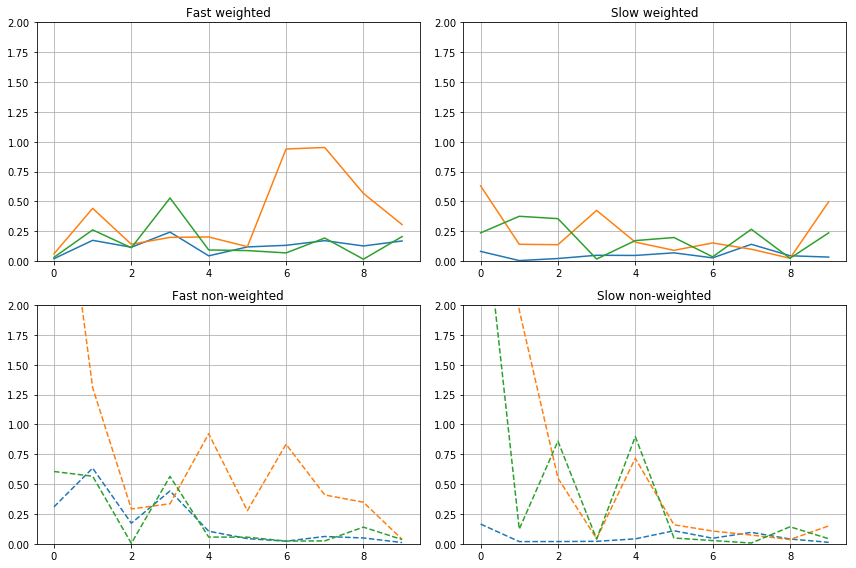

In [597]:
plt.figure(figsize=(12,8))
plt.subplot(221)
plt.plot(eUfast[idxfast])
plt.plot(eVfast[idyfast])
plt.plot(eWfast[idzfast])
plt.title('Fast weighted')
plt.ylim([0,2])
plt.grid()

plt.subplot(222)
plt.plot(eUslow[idxslow])
plt.plot(eVslow[idxslow])
plt.plot(eWslow[idxslow])
plt.title('Slow weighted')
plt.ylim([0,2])
plt.grid()

plt.subplot(223)
plt.plot(eUfast_noweight[idxfast],'--')
plt.plot(eVfast_noweight[idyfast],'--')
plt.plot(eWfast_noweight[idzfast],'--')
plt.title('Fast non-weighted')
plt.ylim([0,2])
plt.grid()

plt.subplot(224)
plt.plot(eUslow_noweight[idxslow],'--', label='X')
plt.plot(eVslow_noweight[idyslow],'--', label='Y')
plt.plot(eWslow_noweight[idzslow],'--', label='Z')
plt.title('Slow non-weighted')
plt.ylim([0,2])
plt.grid()

plt.tight_layout()

In [591]:
xids = np.array([5,6,7,8,9,10])
yids = np.array([1,2,11,12,13,14,15,16])
zids = np.array([3,4,16,17,18,19,20])

In [594]:
eVfast.sel(tracer_num=[1,11,13,15]).values, eVfast_noweight.sel(tracer_num=[1,11,13,15]).values 

(array([0.06170514, 0.44274554, 0.2029337 , 0.95251447], dtype=float32),
 array([3.7644176 , 1.3075342 , 0.9215906 , 0.40908045], dtype=float32))

In [596]:
eVslow.sel(tracer_num=[2,12,14,16]).values, eVslow_noweight.sel(tracer_num=[2,12,14,16]).values

(array([0.09093001, 0.15959024, 0.02456546, 0.498465  ], dtype=float32),
 array([0.15937011, 1.9568197 , 5.60147   , 0.14976357], dtype=float32))

In [544]:
# Overall weighting is helpful. Atleast for this 1 point.

In [623]:
Scorr = 0.5*(Kcorr + Kcorr.T)
Scorr_noweight = 0.5*(Kcorr_noweight + Kcorr_noweight.T)
Acorr = 0.5*(Kcorr - Kcorr.T)
Acorr_noweight = 0.5*(Kcorr_noweight - Kcorr_noweight.T)

In [587]:
evals, evecs = eigen(Scorr)
evals_noweight, evecs_noweight = eigen(Scorr_noweight)

In [588]:
evecs_noweight, evecs

(array([[-4.4318446e-04, -2.8517589e-01,  9.5847511e-01],
        [-1.4052168e-03, -9.5847410e-01, -2.8517625e-01],
        [ 9.9999887e-01, -1.4732509e-03,  2.4046916e-05]], dtype=float32),
 array([[-1.8843687e-04, -3.0173057e-01,  9.5339322e-01],
        [-4.8935943e-04, -9.5339310e-01, -3.0173063e-01],
        [ 9.9999988e-01, -5.2340911e-04,  3.1999731e-05]], dtype=float32))

In [589]:
evals_noweight, evals

(array([ 5.4931641e-03, -1.7226189e+03,  1.4520261e+04], dtype=float32),
 array([ 1.7089844e-03, -3.2182036e+03,  1.4708795e+04], dtype=float32))

In [609]:
# Where are we in location? 
X = T_coarse.XCcoarse
Y = T_coarse.YCcoarse
Z = T_coarse.Z

(-900, 0)

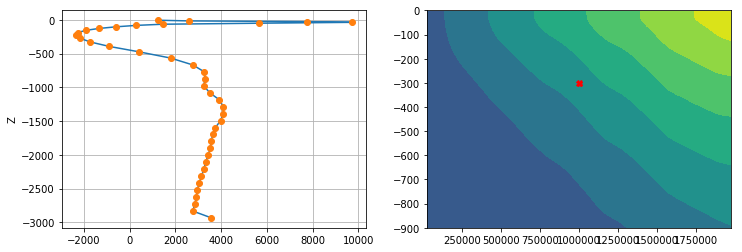

In [622]:
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(diff_tensor.eigvalsST.sel(XCcoarse=xloc, YCcoarse=yloc, method='nearest').isel(ii=1), Z)
plt.plot(diff_tensor_withKPP.eigvalsST.sel(XCcoarse=xloc, YCcoarse=yloc, method='nearest').isel(ii=1), Z,'o')
plt.grid()
plt.ylabel('Z')
# the different between with and without KPP is minor (order 0.002)

plt.subplot(122)
plt.contourf(Y, Z, T_coarse['T'].sel(XCcoarse=xloc, method='nearest'))
plt.plot(yloc, zloc, 'X', color='r')
plt.ylim([-900,0])

In [601]:
# Errors in buoyancy fluxes (Improved by weighting? or worsened?)
[rUb, rVb, rWb, eUb, eVb, eWb] = calc_err(yub, yvb, ywb, E1b, E2b, E3b,Kcorr)
[rUb_noweight, rVb_noweight, rWb_noweight, eUb_noweight, eVb_noweight, eWb_noweight] = calc_err(
    yub, yvb, ywb, E1b, E2b, E3b, Kcorr_noweight)

In [624]:
[rSUb, rSVb, rSWb, eSUb, eSVb, eSWb] = calc_err(yub, yvb, ywb, E1b, E2b, E3b, Scorr)
[rAUb, rAVb, rAWb, eAUb, eAVb, eAWb] = calc_err(yub, yvb, ywb, E1b, E2b, E3b, Acorr)

In [628]:
print (rSUb.values, rAUb.values, rUb.values)
print (rSVb.values, rAVb.values, rVb.values)
print (rSWb.values, rAWb.values, rWb.values)
# both contributions from A and S are equally important. 

0.012292204 0.0010512443 0.013343449
0.014905762 -0.0070657255 0.0078400355
-1.955903e-06 4.946774e-06 2.9908715e-06


In [629]:
print(rUb.values, rUb_noweight.values, yub.values )
print(rVb.values, rVb_noweight.values, yvb.values )
print(rWb.values, rWb_noweight.values, ywb.values )

0.013343449 0.013361326 0.013136029
0.0078400355 0.007659929 0.008530773
2.9908715e-06 3.688794e-06 3.6362655e-06


In [605]:
print(eUb.values, eUb_noweight.values )
print(eVb.values, eVb_noweight.values )
print(eWb.values, eWb_noweight.values )
# There is improvement in horizontal fluxes of b using weighting, at this point.
# Even with negative values of diffusivity (2nd eigenvalue of S),
# the flux of buoyancy is still being reconstructured extremely well. 

0.015790122 0.017151088
0.08097012 0.1020827
0.17748815 0.014445741


In [715]:
# write code for the tracer inversion in vector form, and weight the horizontal and vertical fluxes equally. 
yfastvec = np.concatenate((yufast,yvfast,ywfast))
yslowvec = np.concatenate((yuslow,yvslow,ywslow))

In [717]:
E1vec = np.concatenate((Efast, np.zeros_like(Efast), np.zeros_like(Efast)), axis=1)
E2vec = np.concatenate((np.zeros_like(Efast), Efast, np.zeros_like(Efast)), axis=1)
E3vec = np.concatenate((np.zeros_like(Efast), np.zeros_like(Efast), Efast), axis=1)

Efastvec = np.concatenate((E1vec, E2vec, E3vec), axis=0)

E1vec = np.concatenate((Eslow, np.zeros_like(Eslow), np.zeros_like(Eslow)), axis=1)
E2vec = np.concatenate((np.zeros_like(Eslow), Eslow, np.zeros_like(Eslow)), axis=1)
E3vec = np.concatenate((np.zeros_like(Eslow), np.zeros_like(Eslow), Eslow), axis=1)

Eslowvec = np.concatenate((E1vec, E2vec, E3vec), axis=0)

In [718]:
Kfastvec_noweight = -pinv(Efastvec).dot(yfastvec)
Kfastvec_noweight = Kfastvec_noweight.reshape((3,3))

In [719]:
Kslowvec_noweight = -pinv(Eslowvec).dot(yslowvec)
Kslowvec_noweight = Kslowvec_noweight.reshape((3,3))

In [702]:
W = np.abs(yfastvec)
Kfastvec = -pinv(Efastvec/W[:, None]).dot(yfastvec/W)
Kfastvec = Kfastvec.reshape((3,3))

In [720]:
W = np.abs(yslowvec)
Kslowvec = -pinv(Eslowvec/W[:, None]).dot(yslowvec/W)
Kslowvec = Kslowvec.reshape((3,3))

In [731]:
Kcorrvec = (lam2*Kfastvec - lam1*Kslowvec)/(lam2 - lam1)
Kcorrvec_noweight = (lam2*Kfastvec_noweight - lam1*Kslowvec_noweight)/(lam2 - lam1)

In [706]:
[rUfastvec, rVfastvec, rWfastvec, eUfastvec, eVfastvec, eWfastvec] = calc_err(
    yufast, yvfast, ywfast, E1fast, E2fast, E3fast,Kfastvec)
#[rUslow, rVslow, rWslow, eUslow, eVslow, eWslow] = calc_err(yuslow, yvslow, ywslow, E1slow, E2slow, E3slow,Kslow)

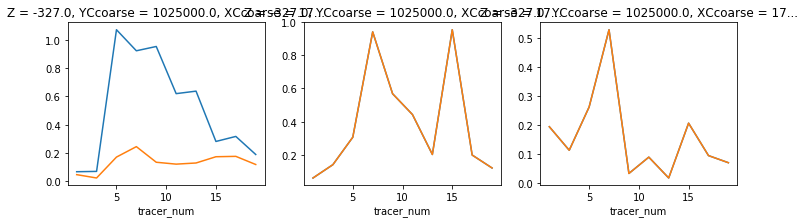

In [708]:
plt.figure(figsize=(12,3))
plt.subplot(131)
eUfastvec.plot()
eUfast.plot()

plt.subplot(132)
eVfastvec.plot()
eVfast.plot()

plt.subplot(133)
eWfastvec.plot()
eWfast.plot()

In [732]:
[rUbvec, rVbvec, rWbvec, eUbvec, eVbvec, eWbvec] = calc_err(yub, yvb, ywb, E1b, E2b, E3b,Kcorrvec)
[rUbvec_noweight, rVbvec_noweight, rWbvec_noweight, eUbvec_noweight, eVbvec_noweight, eWbvec_noweight] = calc_err(yub, yvb, ywb, E1b, E2b, E3b,Kcorrvec_noweight)

In [733]:
print(rUbvec.values,rUbvec_noweight.values, rUb.values, rUb_noweight.values, yub.values )
print(rVbvec.values,rVbvec_noweight.values, rVb.values, rVb_noweight.values, yvb.values )
print(rWbvec.values,rWbvec_noweight.values, rWb.values, rWb_noweight.values, ywb.values )

0.007498331 0.013360982 0.013343449 0.013361326 0.013136029
0.00780206 0.007660925 0.0078400355 0.007659929 0.008530773
2.9904627e-06 3.6887259e-06 2.9908715e-06 3.688794e-06 3.6362655e-06


In [ ]:
# Using the vector form. 
# At this point, while no signficant improvement was seen along 2 of the directions. 
# The results along one of the directions are signficantly corrupted. 

In [ ]:
ST = 0.5*(Ktensor_corr.data + Ktensor_corrT.data)
AT = 0.5*(Ktensor_corr.data - Ktensor_corrT.data)

ST = xr.DataArray(ST, coords=Ktensor_corr.coords, dims=Ktensor_corr.dims)
    AT = xr.DataArray(AT, coords=Ktensor_corr.coords, dims=Ktensor_corr.dims)    
    
    eigvalsST, eigvecsST = xr.apply_ufunc(eigen, ST, input_core_dims=[['i','j']],
                                    vectorize=True, output_core_dims=[['ii'], ['k','ii']])
    

In [212]:
# slow variables
yu= UpCp.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(2,20,2))
yv= VpCp.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(2,20,2))
yw= WpCp.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(2,20,2))
# the number in front of E is the column number 
E1 = dCdx.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(2,20,2))
E2 = dCdy.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(2,20,2))
E3 = dCdz.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(2,20,2))

E = np.stack((E1.data, E2.data, E3.data), axis=1)


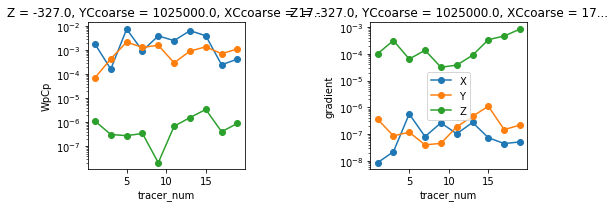

In [276]:
plt.figure(figsize=(8,3))
plt.subplot(121)
np.abs(yu).plot(Marker='o')
np.abs(yv).plot(Marker='o')
np.abs(yw).plot(Marker='o')
plt.yscale('log')

plt.subplot(122)
np.sqrt(E1**2).plot(Marker='o', label='X')
np.sqrt(E2**2).plot(Marker='o', label='Y')
np.sqrt(E3**2).plot(Marker='o', label='Z')

plt.yscale('log')
plt.ylabel('gradient')
plt.legend()

plt.tight_layout()

In [277]:
[xu, ru, rank, s]  = np.linalg.lstsq(-E, yu)
[xv, rv, rank, s]  = np.linalg.lstsq(-E, yv)
[xw, rw, rank, s]  = np.linalg.lstsq(-E, yw)

# residual is the 2norm squared (X^2)

/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.
/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  
/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the

In [227]:
print(xu)
print(xv)
print(xw)

[ 1.4372702e+04 -4.7869805e+03 -4.6023492e-02]
[-3.8372952e+03  1.3263597e+03 -1.0686684e+00]
[-2.4811013e-01 -3.5962968e+00  1.9845020e-03]


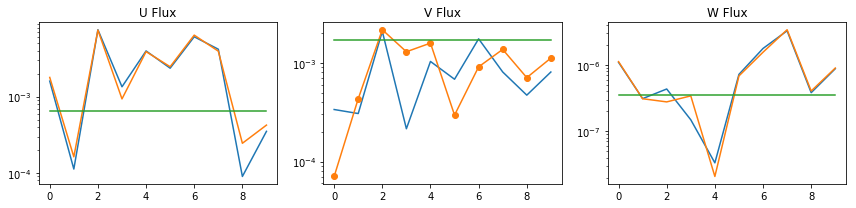

In [228]:
plt.figure(figsize=(12,3))
plt.subplot(131)
plt.plot(np.abs(np.matmul(E, xu)))
plt.plot(np.abs(yu))
plt.plot(yu/yu*ru**0.5)
plt.yscale('log')
plt.title('U Flux')

plt.subplot(132)
plt.plot(np.abs(np.matmul(E, xv)))
plt.plot(np.abs(yv), 'o-')
plt.plot(yu/yu*rv**0.5)
plt.yscale('log')
plt.title('V Flux')

plt.subplot(133)
plt.plot(np.abs(np.matmul(E, xw)))
plt.plot(np.abs(yw))
plt.plot(yu/yu*rw**0.5)
plt.yscale('log')
plt.title('W Flux')

plt.tight_layout()

In [229]:
np.linalg.norm(np.matmul(E, xv) - yv)

0.006764104

In [230]:
print(ru**0.5)
print(rv**0.5)
print(rw**0.5)

[0.0006498]
[0.0016981]
[3.562149e-07]


Least squares minimizes a weighting function 
$J = \sum n_i^2 =  (y- Ex)^T (y - Ex)$, which is the sum of squared error. where the sum is over all observations. 

A weight matrix weights each row of this, in any way that might be appropriate for the problem. 


In [231]:
# Weighted 
W = yu.values
[xuw, ruw, rank, s]  = np.linalg.lstsq(-E/W[:,None], yu/W)
W = yv.values
[xvw, rvw, rank, s]  = np.linalg.lstsq(-E/W[:,None], yv/W)
W = yw.values
[xww, rww, rank, s]  = np.linalg.lstsq(-E/W[:,None], yw/W)

/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """
/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times 

In [233]:
print(xu)
print(xv)
print(xw)

[ 1.4372702e+04 -4.7869805e+03 -4.6023492e-02]
[-3.8372952e+03  1.3263597e+03 -1.0686684e+00]
[-2.4811013e-01 -3.5962968e+00  1.9845020e-03]


In [234]:
print(xuw)
print(xvw)
print(xww)

[ 1.2031419e+04 -5.0523784e+03  1.8132951e-02]
[-2.6451406e+03  5.9487109e+02 -1.1574528e+00]
[-2.0632707e-01 -3.0549622e+00  1.9404695e-03]


In [235]:
print(np.linalg.norm(np.matmul(E, xu) - yu))
print(np.linalg.norm(np.matmul(E, xv) - yv))
print(np.linalg.norm(np.matmul(E, xw) - yw))

0.02353329
0.006764104
8.2165625e-06


In [236]:
print(np.linalg.norm(np.matmul(E, xuw) - yu), np.linalg.norm(yu))
print(np.linalg.norm(np.matmul(E, xvw) - yv), np.linalg.norm(yv))
print(np.linalg.norm(np.matmul(E, xww) - yw), np.linalg.norm(yw))

0.022342222 0.011780094
0.0058103986 0.0036879447
7.602618e-06 4.1198473e-06


### Error analysis

In [237]:
idx = np.argsort(np.abs(yu.values))
idy = np.argsort(np.abs(yv.values))
idz = np.argsort(np.abs(yw.values))

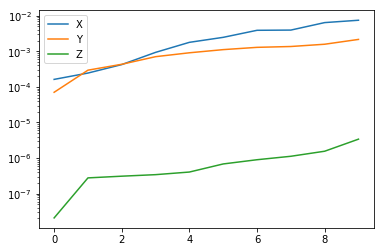

In [238]:
plt.plot(np.abs(yu[idx]), label='X')
plt.plot(np.abs(yv[idy]), label='Y')
plt.plot(np.abs(yw[idz]), label='Z')
plt.yscale('log')
plt.legend()

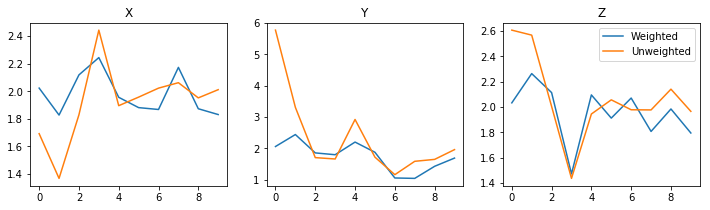

In [239]:
plt.figure(figsize=(12,3))
plt.subplot(131)
plt.plot((np.abs(np.matmul(E, xuw) - yu)/np.abs(yu))[idx])
plt.plot((np.abs(np.matmul(E, xu) - yu)/np.abs(yu))[idx])
plt.title('X')

plt.subplot(132)
plt.plot((np.abs(np.matmul(E, xvw) - yv)/np.abs(yv))[idy])
plt.plot((np.abs(np.matmul(E, xv) - yv)/np.abs(yv))[idy])
plt.title('Y')

plt.subplot(133)
plt.plot((np.abs(np.matmul(E, xww) - yw)/np.abs(yw))[idz], label='Weighted')
plt.plot((np.abs(np.matmul(E, xw) - yw)/np.abs(yw))[idz], label='Unweighted')
plt.title('Z')
plt.legend()

Weighting helps! 

In [218]:
K = np.stack((xu,xv,xw), axis=0)
S = 0.5*(K + K.T)

In [219]:
eigen(S)

(array([ 6.2255859e-03, -1.4305133e+03,  1.4713112e+04], dtype=float32),
 array([[-5.2273110e-04, -2.8561756e-01,  9.5834357e-01],
        [-1.6636333e-03, -9.5834213e-01, -2.8561804e-01],
        [ 9.9999851e-01, -1.7436335e-03,  2.5792322e-05]], dtype=float32))

In [221]:
s

array([1.5775398e+04, 1.1381283e+01, 7.9106456e-01], dtype=float32)

In [ ]:
# Full 3D problem 



# Working using pseudo inverse 

In [242]:
# make sure the eigen values are arranged by magnitude (instead of the default arrangement)
def eigen(A):
    eigenValues, eigenVectors = eigh(A)
    idx = np.argsort(np.abs(eigenValues))
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return (eigenValues, eigenVectors)

In [265]:
Ktensor_fast = xr.apply_ufunc(calc_tensor, 
                       UpCp.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(1,19,2)),
                       VpCp.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(1,19,2)),
                       WpCp.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(1,19,2)),
                       dCdx.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(1,19,2)),
                       dCdy.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(1,19,2)),
                       dCdz.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(1,19,2)),
                       input_core_dims=[['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num']],
                       vectorize=True, output_core_dims=[['i','j']], dask='parallelized', 
                       output_dtypes=['float32'], output_sizes={'i':3,'j':3})

In [266]:
Ktensor_fast

<xarray.DataArray (i: 3, j: 3)>
array([[ 1.437218e+04, -4.787078e+03, -4.557719e-02],
       [-3.837155e+03,  1.326386e+03, -1.068788e+00],
       [-2.481008e-01, -3.596295e+00,  1.984492e-03]], dtype=float32)
Coordinates:
    Z            float32 -327.0
    YCcoarse     float32 1025000.0
    XCcoarse     float32 1725000.0
    hFacCcoarse  float32 1.0
    PHrefC       float32 3207.87
    drF          float32 60.0
Dimensions without coordinates: i, j

In [267]:
print(xuw)
print(xvw)
print(xww)

[ 1.2031419e+04 -5.0523784e+03  1.8132951e-02]
[-2.6451406e+03  5.9487109e+02 -1.1574528e+00]
[-2.0632707e-01 -3.0549622e+00  1.9404695e-03]


In [268]:
def flux_reconstruct(tensor, flux, grads):

    recUflux = -(tensor.sel(i=0, j=0)*grads.dCdx + tensor.sel(i=0, j=1)*grads.dCdy + tensor.sel(i=0, j=2)*grads.dCdz)
    recVflux = -(tensor.sel(i=1, j=0)*grads.dCdx + tensor.sel(i=1, j=1)*grads.dCdy + tensor.sel(i=1, j=2)*grads.dCdz)
    recWflux = -(tensor.sel(i=2, j=0)*grads.dCdx + tensor.sel(i=2, j=1)*grads.dCdy + tensor.sel(i=2, j=2)*grads.dCdz)

    errU = np.abs(flux.UpCp - recUflux)/np.abs(flux.UpCp)
    errV = np.abs(flux.VpCp - recVflux)/np.abs(flux.VpCp)
    errW = np.abs(flux.WpCp - recWflux)/np.abs(flux.WpCp)
    
    flux_rec=xr.Dataset({'UpCp':recUflux, 'VpCp':recVflux, 'WpCp':recWflux,
                                'errU':errU, 'errV':errV, 'errW':errW})
    
    return flux_rec

In [269]:
# analyzed flux 
[UpCp, VpCp, WpCp] = get_flux_arrays(Trac_coarse, list_trac)
[dCdx, dCdy, dCdz]= get_grad_arrays(Trac_coarse, list_trac)
flux = xr.Dataset({'UpCp':UpCp, 'VpCp':VpCp, 'WpCp':WpCp})
grads = xr.Dataset({'dCdx':dCdx, 'dCdy':dCdy, 'dCdz':dCdz})

In [270]:
flux_rec =flux_reconstruct( Ktensor_fast, 
                           flux.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(1,19,2)), 
                            grads.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(1,19,2)))

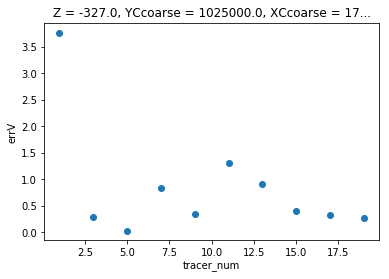

In [271]:
flux_rec.errV.plot.line('o')

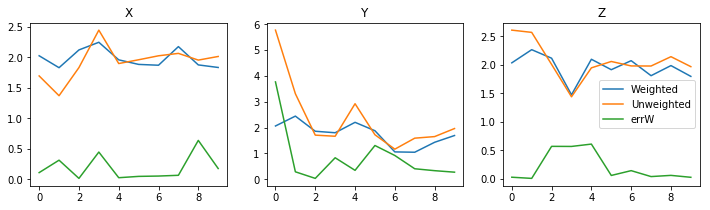

In [274]:
plt.figure(figsize=(12,3))
plt.subplot(131)
plt.plot((np.abs(np.matmul(E, xuw) - yu)/np.abs(yu))[idx])
plt.plot((np.abs(np.matmul(E, xu) - yu)/np.abs(yu))[idx])
plt.plot(flux_rec.errU)
plt.title('X')

plt.subplot(132)
plt.plot((np.abs(np.matmul(E, xvw) - yv)/np.abs(yv))[idy])
plt.plot((np.abs(np.matmul(E, xv) - yv)/np.abs(yv))[idy])
plt.plot(flux_rec.errV)
plt.title('Y')

plt.subplot(133)
plt.plot((np.abs(np.matmul(E, xww) - yw)/np.abs(yw))[idz], label='Weighted')
plt.plot((np.abs(np.matmul(E, xw) - yw)/np.abs(yw))[idz], label='Unweighted')
plt.plot(flux_rec.errW)
plt.title('Z')
plt.legend()

# Old

In [50]:
def do_it_all(UpCp, VpCp, WpCp, dCdx, dCdy, dCdz, xloc, yloc, zloc): 


    Ktensor_fast = xr.apply_ufunc(calc_tensor, 
                       UpCp.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(1,9,2)),
                       VpCp.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(1,9,2)),
                       WpCp.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(1,9,2)),
                       dCdx.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(1,9,2)),
                       dCdy.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(1,9,2)),
                       dCdz.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(1,9,2)),
                       input_core_dims=[['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num']],
                       vectorize=True, output_core_dims=[['i','j']], dask='parallelized', 
                       output_dtypes=['float32'], output_sizes={'i':3,'j':3})

    Ktensor_slow = xr.apply_ufunc(calc_tensor, 
                       UpCp.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(2,10,2)),
                       VpCp.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(2,10,2)),
                       WpCp.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(2,10,2)),
                       dCdx.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(2,10,2)),
                       dCdy.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(2,10,2)),
                       dCdz.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(2,10,2)),
                       input_core_dims=[['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num']],
                       vectorize=True, output_core_dims=[['i','j']], dask='parallelized', 
                       output_dtypes=['float32'], output_sizes={'i':3,'j':3})
    lam1 = 1/31104000.
    lam2 = 1/186624000.

    Ktensor_corr = (lam2*Ktensor_fast - lam1*Ktensor_slow)/(lam2 - lam1)
    
    Ktensor_corrT = Ktensor_corr.transpose('j','i')

    ST = 0.5*(Ktensor_corr.data + Ktensor_corrT.data)
    AT = 0.5*(Ktensor_corr.data - Ktensor_corrT.data)

    ST = xr.DataArray(ST, coords=Ktensor_corr.coords, dims=Ktensor_corr.dims)
    AT = xr.DataArray(AT, coords=Ktensor_corr.coords, dims=Ktensor_corr.dims)    
    
    eigvalsST, eigvecsST = xr.apply_ufunc(eigen, ST, input_core_dims=[['i','j']],
                                    vectorize=True, output_core_dims=[['ii'], ['k','ii']])
    
    diff_tensor = xr.Dataset()
    diff_tensor['Kfast'] = Ktensor_fast
    diff_tensor['Kslow'] = Ktensor_slow
    diff_tensor['Kcorr'] = Ktensor_corr
    diff_tensor['ST'] = ST
    diff_tensor['AT'] = AT
    diff_tensor['eigvalsST'] = np.real(eigvalsST)
    diff_tensor['eigvecsST'] = eigvecsST
    
    return diff_tensor

In [51]:
diff_tensor = do_it_all(UpCp, VpCp,WpCp, dCdx, dCdy, dCdz, xloc, yloc, zloc)

In [52]:
diff_tensor.Kfast

<xarray.DataArray 'Kfast' (i: 3, j: 3)>
array([[ 1.416179e+04, -5.374490e+03,  4.806228e-01],
       [-4.530215e+03,  6.471646e+02,  1.539606e-01],
       [-7.605629e-02, -3.689539e+00,  2.259521e-03]], dtype=float32)
Coordinates:
    Z            float32 -327.0
    YCcoarse     float32 1025000.0
    XCcoarse     float32 1725000.0
    hFacCcoarse  float32 1.0
    PHrefC       float32 3207.87
    drF          float32 60.0
Dimensions without coordinates: i, j

In [134]:
E1.data

array([ 8.4972385e-09,  3.2321214e-08, -2.1869541e-08, -1.7714799e-08,
        5.6552426e-07,  1.0559376e-07, -8.0392361e-08, -2.5758817e-08,
       -2.6250876e-07, -4.6465399e-08,  1.0270238e-07,  2.8499365e-08,
       -2.7141451e-07, -7.4956418e-08, -7.3056221e-08, -9.0454222e-08,
        4.4180155e-08,  3.8062336e-08,  5.0866007e-08,  3.7271381e-08],
      dtype=float32)

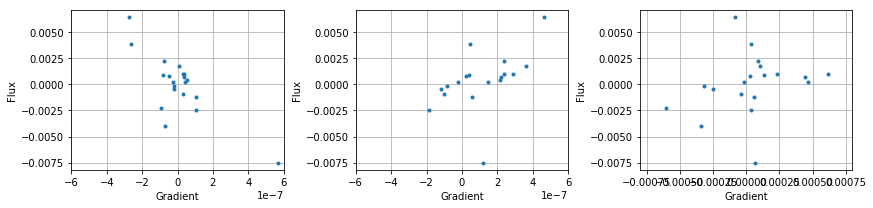

In [15]:
plt.figure(figsize=(12,3))

plt.subplot(131)
plt.plot(dCdx.sel(Z=-300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest')
    ,UpCp.sel(Z=-300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest'),'.')
plt.xlabel('Gradient')
plt.ylabel('Flux')
plt.xlim([-6e-7, 6e-7])
plt.grid()

plt.subplot(132)
plt.plot(dCdy.sel(Z=-300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest')
    ,UpCp.sel(Z=-300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest'),'.')
plt.xlabel('Gradient')
plt.ylabel('Flux')
plt.xlim([-6e-7, 6e-7])
plt.grid()

plt.subplot(133)
plt.plot(dCdz.sel(Z=-300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest')
    ,UpCp.sel(Z=-300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest'),'.')
plt.xlabel('Gradient')
plt.ylabel('Flux')
plt.xlim([-8e-4, 8e-4])
plt.grid()

plt.tight_layout()

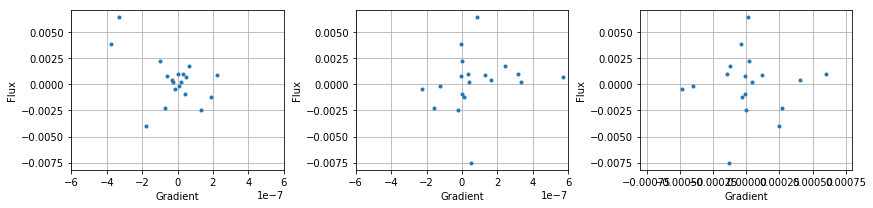

In [16]:
plt.figure(figsize=(12,3))

plt.subplot(131)
plt.plot(dCdx.sel(Z=-1300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest')
    ,UpCp.sel(Z=-300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest'),'.')
plt.xlabel('Gradient')
plt.ylabel('Flux')
plt.xlim([-6e-7, 6e-7])
plt.grid()

plt.subplot(132)
plt.plot(dCdy.sel(Z=-1300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest')
    ,UpCp.sel(Z=-300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest'),'.')
plt.xlabel('Gradient')
plt.ylabel('Flux')
plt.xlim([-6e-7, 6e-7])
plt.grid()

plt.subplot(133)
plt.plot(dCdz.sel(Z=-1300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest')
    ,UpCp.sel(Z=-300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest'),'.')
plt.xlabel('Gradient')
plt.ylabel('Flux')
plt.xlim([-8e-4, 8e-4])
plt.grid()

plt.tight_layout()

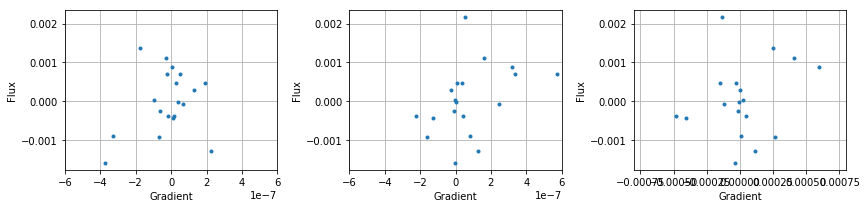

In [17]:
plt.figure(figsize=(12,3))

plt.subplot(131)
plt.plot(dCdx.sel(Z=-1300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest')
    ,VpCp.sel(Z=-300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest'),'.')
plt.xlabel('Gradient')
plt.ylabel('Flux')
plt.xlim([-6e-7, 6e-7])
plt.grid()

plt.subplot(132)
plt.plot(dCdy.sel(Z=-1300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest')
    ,VpCp.sel(Z=-300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest'),'.')
plt.xlabel('Gradient')
plt.ylabel('Flux')
plt.xlim([-6e-7, 6e-7])
plt.grid()

plt.subplot(133)
plt.plot(dCdz.sel(Z=-1300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest')
    ,VpCp.sel(Z=-300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest'),'.')
plt.xlabel('Gradient')
plt.ylabel('Flux')
plt.xlim([-8e-4, 8e-4])
plt.grid()

plt.tight_layout()

# Tracers for 3D setup (with ridge in the middle.)
$$C1 = yg/Lx$$
$$C2 = (-zg)/H$$
$$C3 = np.cos(2*np.pi*xg/Lx) $$
$$C4 = np.sin(2*np.pi*xg/Lx)$$
$$C5 = np.sin(4*np.pi*xg/Lx)$$
$$C6 = np.sin(np.pi*yg/Lx)$$
$$C7 = np.cos(2*np.pi*yg/Lx)$$
$$C8 = np.sin(2*np.pi*yg/Lx)$$
$$C9 = np.cos(np.pi*zg/H)$$
$$C10 = np.sin(np.pi*zg/H)$$

In [73]:
xids = np.array([5,6,7,8,9,10])
yids = np.array([1,2,11,12,13,14,15,16])
zids = np.array([3,4,16,17,18,19,20])

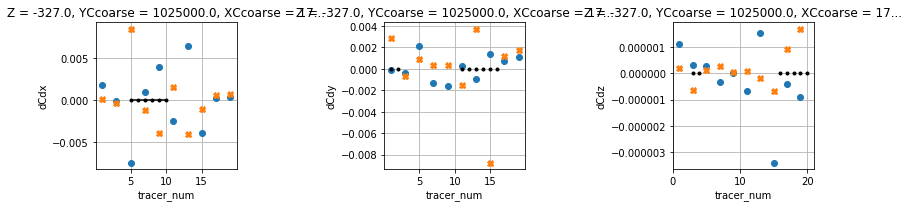

In [85]:
plt.figure(figsize=(12,3))

plt.subplot(131)
UpCp.sel(Z=-300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(
    tracer_num=slice(1,19,2)).plot.line('o')
(15000*dCdx).sel(Z=-300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(
    tracer_num=slice(1,19,2)).plot.line('X')
plt.plot(xids, xids*0, '.-', color='k')
plt.grid()

plt.subplot(132)
VpCp.sel(Z=-300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(
    tracer_num=slice(1,19,2)).plot.line('o')
(8000*dCdy).sel(Z=-300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(
    tracer_num=slice(1,19,2)).plot.line('X')
plt.plot(yids, yids*0, '.', color='k')
plt.grid()

plt.subplot(133)
WpCp.sel(Z=-300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(
    tracer_num=slice(1,19,2)).plot.line('o')
(2e-3*dCdz).sel(Z=-300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(
    tracer_num=slice(1,19,2)).plot.line('X')
plt.plot(zids, zids*0, '.', color='k')
plt.grid()

plt.tight_layout()

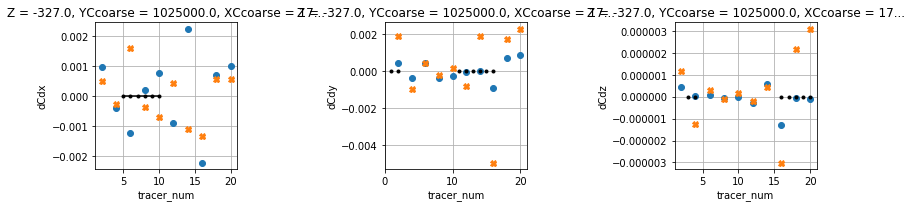

In [83]:
plt.figure(figsize=(12,3))

plt.subplot(131)
UpCp.sel(Z=-300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(
    tracer_num=slice(2,20,2)).plot.line('o')
(15000*dCdx).sel(Z=-300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(
    tracer_num=slice(2,20,2)).plot.line('X')
plt.plot(xids, xids*0, '.-', color='k')
plt.grid()

plt.subplot(132)
VpCp.sel(Z=-300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(
    tracer_num=slice(2,20,2)).plot.line('o')
(8000*dCdy).sel(Z=-300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(
    tracer_num=slice(2,20,2)).plot.line('X')
plt.plot(yids, yids*0, '.', color='k')
plt.grid()

plt.subplot(133)
WpCp.sel(Z=-300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(
    tracer_num=slice(2,20,2)).plot.line('o')
(5e-3*dCdz).sel(Z=-300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(
    tracer_num=slice(2,20,2)).plot.line('X')
plt.plot(zids, zids*0, '.', color='k')
plt.grid()

plt.tight_layout()

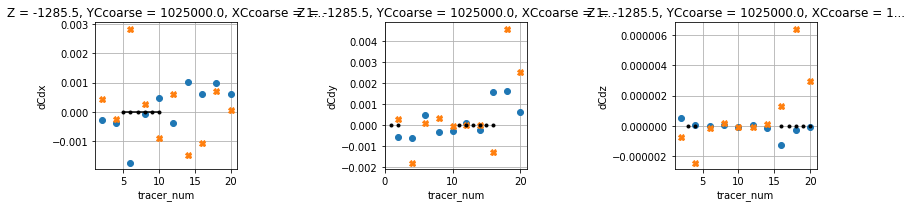

In [84]:
plt.figure(figsize=(12,3))

plt.subplot(131)
UpCp.sel(Z=-1300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(
    tracer_num=slice(2,20,2)).plot.line('o')
(15000*dCdx).sel(Z=-1300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(
    tracer_num=slice(2,20,2)).plot.line('X')
plt.plot(xids, xids*0, '.-', color='k')
plt.grid()

plt.subplot(132)
VpCp.sel(Z=-1300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(
    tracer_num=slice(2,20,2)).plot.line('o')
(8000*dCdy).sel(Z=-1300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(
    tracer_num=slice(2,20,2)).plot.line('X')
plt.plot(yids, yids*0, '.', color='k')
plt.grid()

plt.subplot(133)
WpCp.sel(Z=-1300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(
    tracer_num=slice(2,20,2)).plot.line('o')
(5e-3*dCdz).sel(Z=-1300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(
    tracer_num=slice(2,20,2)).plot.line('X')
plt.plot(zids, zids*0, '.', color='k')
plt.grid()

plt.tight_layout()

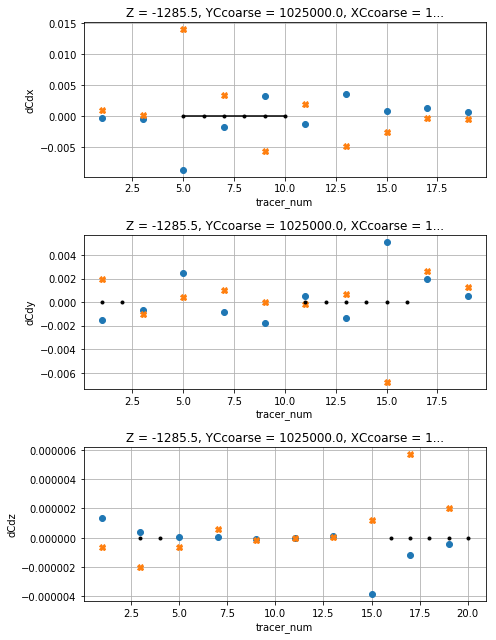

In [93]:
plt.figure(figsize=(7,9))

plt.subplot(311)
UpCp.sel(Z=-1300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(
    tracer_num=slice(1,19,2)).plot.line('o')
(15000*dCdx).sel(Z=-1300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(
    tracer_num=slice(1,19,2)).plot.line('X')
plt.plot(xids, xids*0, '.-', color='k')
plt.grid()

plt.subplot(312)
VpCp.sel(Z=-1300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(
    tracer_num=slice(1,19,2)).plot.line('o')
(8000*dCdy).sel(Z=-1300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(
    tracer_num=slice(1,19,2)).plot.line('X')
plt.plot(yids, yids*0, '.', color='k')
plt.grid()

plt.subplot(313)
WpCp.sel(Z=-1300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(
    tracer_num=slice(1,19,2)).plot.line('o')
(5e-3*dCdz).sel(Z=-1300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(
    tracer_num=slice(1,19,2)).plot.line('X')
plt.plot(zids, zids*0, '.', color='k')
plt.grid()

plt.tight_layout()

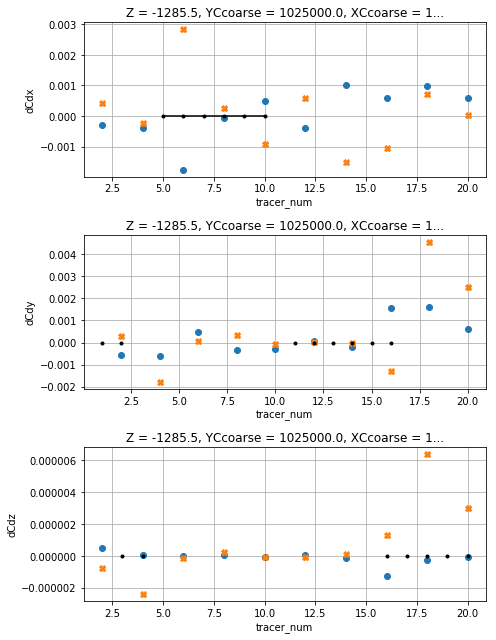

In [89]:
plt.figure(figsize=(7,9))

plt.subplot(311)
UpCp.sel(Z=-1300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(
    tracer_num=slice(2,20,2)).plot.line('o')
(15000*dCdx).sel(Z=-1300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(
    tracer_num=slice(2,20,2)).plot.line('X')
plt.plot(xids, xids*0, '.-', color='k')
plt.grid()

plt.subplot(312)
VpCp.sel(Z=-1300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(
    tracer_num=slice(2,20,2)).plot.line('o')
(8000*dCdy).sel(Z=-1300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(
    tracer_num=slice(2,20,2)).plot.line('X')
plt.plot(yids, yids*0, '.', color='k')
plt.grid()

plt.subplot(313)
WpCp.sel(Z=-1300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(
    tracer_num=slice(2,20,2)).plot.line('o')
(5e-3*dCdz).sel(Z=-1300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(
    tracer_num=slice(2,20,2)).plot.line('X')
plt.plot(zids, zids*0, '.', color='k')
plt.grid()

plt.tight_layout()

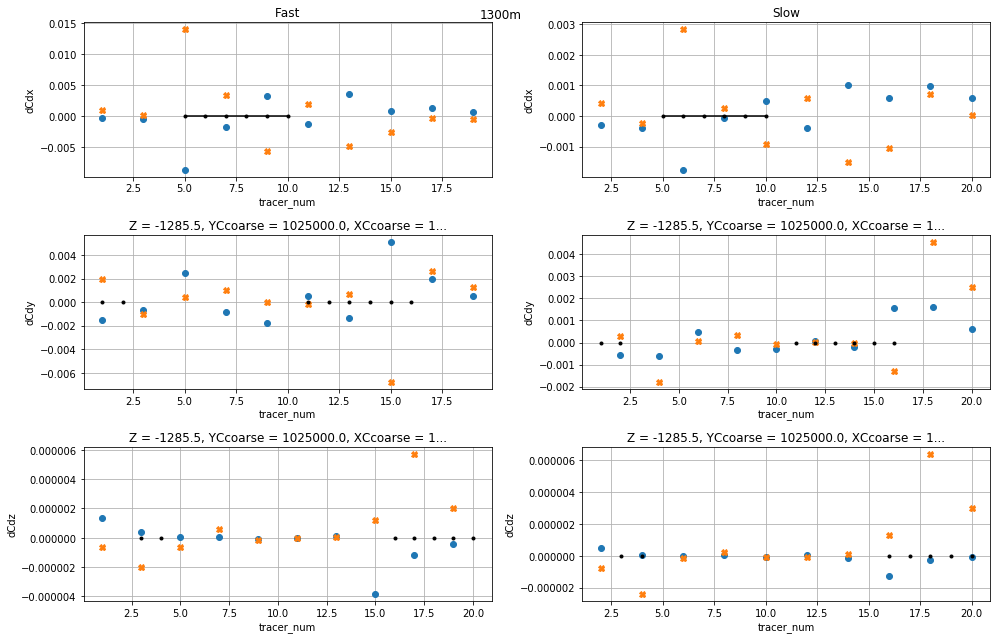

In [103]:
plt.figure(figsize=(14,9))

plt.subplot(321)
UpCp.sel(Z=-1300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(
    tracer_num=slice(1,19,2)).plot.line('o')
(15000*dCdx).sel(Z=-1300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(
    tracer_num=slice(1,19,2)).plot.line('X')
plt.plot(xids, xids*0, '.-', color='k')
plt.title('Fast')
plt.grid()

plt.subplot(323)
VpCp.sel(Z=-1300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(
    tracer_num=slice(1,19,2)).plot.line('o')
(8000*dCdy).sel(Z=-1300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(
    tracer_num=slice(1,19,2)).plot.line('X')
plt.plot(yids, yids*0, '.', color='k')
plt.grid()

plt.subplot(325)
WpCp.sel(Z=-1300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(
    tracer_num=slice(1,19,2)).plot.line('o')
(5e-3*dCdz).sel(Z=-1300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(
    tracer_num=slice(1,19,2)).plot.line('X')
plt.plot(zids, zids*0, '.', color='k')
plt.grid()


plt.subplot(322)
UpCp.sel(Z=-1300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(
    tracer_num=slice(2,20,2)).plot.line('o')
(15000*dCdx).sel(Z=-1300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(
    tracer_num=slice(2,20,2)).plot.line('X')
plt.plot(xids, xids*0, '.-', color='k')
plt.title('Slow')
plt.grid()

plt.subplot(324)
VpCp.sel(Z=-1300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(
    tracer_num=slice(2,20,2)).plot.line('o')
(8000*dCdy).sel(Z=-1300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(
    tracer_num=slice(2,20,2)).plot.line('X')
plt.plot(yids, yids*0, '.', color='k')
plt.grid()

plt.subplot(326)
WpCp.sel(Z=-1300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(
    tracer_num=slice(2,20,2)).plot.line('o')
(5e-3*dCdz).sel(Z=-1300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(
    tracer_num=slice(2,20,2)).plot.line('X')
plt.plot(zids, zids*0, '.', color='k')
plt.grid()

plt.suptitle('1300m')
plt.tight_layout()

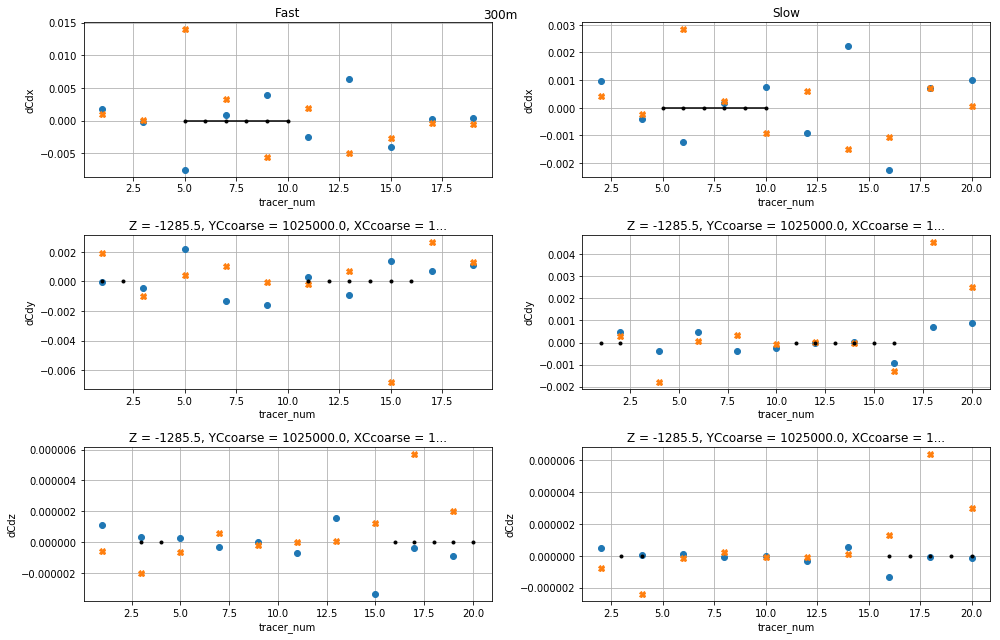

In [100]:
plt.figure(figsize=(14,9))

plt.subplot(321)
UpCp.sel(Z=-300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(
    tracer_num=slice(1,19,2)).plot.line('o')
(15000*dCdx).sel(Z=-1300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(
    tracer_num=slice(1,19,2)).plot.line('X')
plt.plot(xids, xids*0, '.-', color='k')
plt.title('Fast')
plt.grid()

plt.subplot(323)
VpCp.sel(Z=-300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(
    tracer_num=slice(1,19,2)).plot.line('o')
(8000*dCdy).sel(Z=-1300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(
    tracer_num=slice(1,19,2)).plot.line('X')
plt.plot(yids, yids*0, '.', color='k')
plt.grid()

plt.subplot(325)
WpCp.sel(Z=-300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(
    tracer_num=slice(1,19,2)).plot.line('o')
(5e-3*dCdz).sel(Z=-1300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(
    tracer_num=slice(1,19,2)).plot.line('X')
plt.plot(zids, zids*0, '.', color='k')
plt.grid()


plt.subplot(322)
UpCp.sel(Z=-300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(
    tracer_num=slice(2,20,2)).plot.line('o')
(15000*dCdx).sel(Z=-1300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(
    tracer_num=slice(2,20,2)).plot.line('X')
plt.plot(xids, xids*0, '.-', color='k')
plt.title('Slow')
plt.grid()

plt.subplot(324)
VpCp.sel(Z=-300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(
    tracer_num=slice(2,20,2)).plot.line('o')
(8000*dCdy).sel(Z=-1300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(
    tracer_num=slice(2,20,2)).plot.line('X')
plt.plot(yids, yids*0, '.', color='k')
plt.grid()

plt.subplot(326)
WpCp.sel(Z=-300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(
    tracer_num=slice(2,20,2)).plot.line('o')
(5e-3*dCdz).sel(Z=-1300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(
    tracer_num=slice(2,20,2)).plot.line('X')
plt.plot(zids, zids*0, '.', color='k')
plt.grid()

plt.suptitle('300m')
plt.tight_layout()

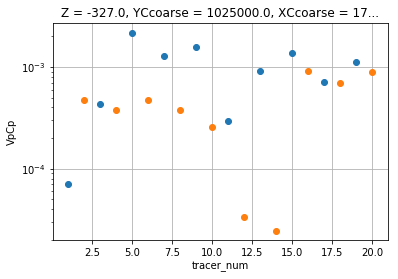

In [113]:
np.abs(VpCp).sel(Z=-300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(
    tracer_num=slice(1,19,2)).plot.line('o')
np.abs(VpCp).sel(Z=-300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(
    tracer_num=slice(2,20,2)).plot.line('o')
plt.yscale('log')
plt.plot(yids, yids*0, '.', color='k')
plt.grid()

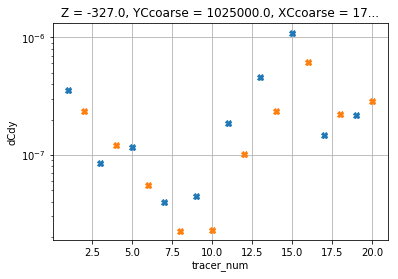

In [114]:
np.abs(dCdy).sel(Z=-300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(
    tracer_num=slice(1,19,2)).plot.line('X')
np.abs(dCdy).sel(Z=-300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(
    tracer_num=slice(2,20,2)).plot.line('X')
plt.yscale('log')
plt.plot(yids, yids*0, '.', color='k')
plt.grid()

In [18]:
%%time
# Calculate the tensor
# This is slow (can take over an hour)

Ktensor_fast = xr.apply_ufunc(calc_tensor, 
                       UpCp.sel(Z=-1300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(tracer_num=slice(1,19,2)),
                       VpCp.sel(Z=-1300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(tracer_num=slice(1,19,2)),
                       WpCp.sel(Z=-1300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(tracer_num=slice(1,19,2)),
                       dCdx.sel(Z=-1300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(tracer_num=slice(1,19,2)),
                       dCdy.sel(Z=-1300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(tracer_num=slice(1,19,2)),
                       dCdz.sel(Z=-1300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(tracer_num=slice(1,19,2)),
                       input_core_dims=[['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num']],
                       vectorize=True, output_core_dims=[['i','j']], dask='parallelized', 
                       output_dtypes=['float32'], output_sizes={'i':3,'j':3})

Ktensor_fast.load() # need to load because we will take transpose and a

CPU times: user 74.8 ms, sys: 16.6 ms, total: 91.4 ms
Wall time: 212 ms


In [19]:
%%time
# Calculate the tensor
# This is slow (can take over an hour)

Ktensor_slow = xr.apply_ufunc(calc_tensor, 
                       UpCp.sel(Z=-1300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(tracer_num=slice(2,20,2)),
                       VpCp.sel(Z=-1300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(tracer_num=slice(2,20,2)),
                       WpCp.sel(Z=-1300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(tracer_num=slice(2,20,2)),
                       dCdx.sel(Z=-1300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(tracer_num=slice(2,20,2)),
                       dCdy.sel(Z=-1300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(tracer_num=slice(2,20,2)),
                       dCdz.sel(Z=-1300, YCcoarse=1000e3, XCcoarse=1700e3, method='nearest').sel(tracer_num=slice(2,20,2)),
                       input_core_dims=[['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num']],
                       vectorize=True, output_core_dims=[['i','j']], dask='parallelized', 
                       output_dtypes=['float32'], output_sizes={'i':3,'j':3})

Ktensor_slow.load() # need to load because we will take transpose and a

CPU times: user 58.9 ms, sys: 1.68 ms, total: 60.6 ms
Wall time: 56.7 ms


In [20]:
lam1 = 1/31104000.
lam2 = 1/186624000.

Ktensor_corr = (lam2*Ktensor_fast - lam1*Ktensor_slow)/(lam2 - lam1)

In [22]:
Ktensor_corrT = Ktensor_corr.transpose('j','i')

ST = 0.5*(Ktensor_corr.data + Ktensor_corrT.data)
AT = 0.5*(Ktensor_corr.data - Ktensor_corrT.data)

ST = xr.DataArray(ST, coords=Ktensor_corr.coords, dims=Ktensor_corr.dims)
AT = xr.DataArray(AT, coords=Ktensor_corr.coords, dims=Ktensor_corr.dims)

In [24]:
# make sure the eigen values are arranged by magnitude (instead of the default arrangement)
def eigen(A):
    eigenValues, eigenVectors = eigh(A)
    idx = np.argsort(np.abs(eigenValues))
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return (eigenValues, eigenVectors)

In [775]:
# calculate the eigenvalues and eigenvectors of symmetric part
eigvalsST, eigvecsST = xr.apply_ufunc(eig, ST, input_core_dims=[['i','j']],
                                    vectorize=True, output_core_dims=[['ii'], ['k','ii']])

NameError: name 'ST' is not defined

In [26]:
eigvalsST

<xarray.DataArray (ii: 3)>
array([    0.    ,  4095.1055, 10221.545 ], dtype=float32)
Coordinates:
    Z            float32 -1285.5
    YCcoarse     float32 1025000.0
    XCcoarse     float32 1725000.0
    hFacCcoarse  float32 1.0
    PHrefC       float32 12610.755
    drF          float32 103.0
Dimensions without coordinates: ii

In [31]:
def do_it_all(UpCp, VpCp, WpCp, dCdx, dCdy, dCdz, xloc, yloc, zloc): 


    Ktensor_fast = xr.apply_ufunc(calc_tensor, 
                       UpCp.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(1,9,2)),
                       VpCp.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(1,9,2)),
                       WpCp.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(1,9,2)),
                       dCdx.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(1,9,2)),
                       dCdy.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(1,9,2)),
                       dCdz.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(1,9,2)),
                       input_core_dims=[['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num']],
                       vectorize=True, output_core_dims=[['i','j']], dask='parallelized', 
                       output_dtypes=['float32'], output_sizes={'i':3,'j':3})

    Ktensor_slow = xr.apply_ufunc(calc_tensor, 
                       UpCp.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(2,10,2)),
                       VpCp.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(2,10,2)),
                       WpCp.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(2,10,2)),
                       dCdx.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(2,10,2)),
                       dCdy.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(2,10,2)),
                       dCdz.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(2,10,2)),
                       input_core_dims=[['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num']],
                       vectorize=True, output_core_dims=[['i','j']], dask='parallelized', 
                       output_dtypes=['float32'], output_sizes={'i':3,'j':3})
    lam1 = 1/31104000.
    lam2 = 1/186624000.

    Ktensor_corr = (lam2*Ktensor_fast - lam1*Ktensor_slow)/(lam2 - lam1)
    
    Ktensor_corrT = Ktensor_corr.transpose('j','i')

    ST = 0.5*(Ktensor_corr.data + Ktensor_corrT.data)
    AT = 0.5*(Ktensor_corr.data - Ktensor_corrT.data)

    ST = xr.DataArray(ST, coords=Ktensor_corr.coords, dims=Ktensor_corr.dims)
    AT = xr.DataArray(AT, coords=Ktensor_corr.coords, dims=Ktensor_corr.dims)    
    
    eigvalsST, eigvecsST = xr.apply_ufunc(eigen, ST, input_core_dims=[['i','j']],
                                    vectorize=True, output_core_dims=[['ii'], ['k','ii']])
    
    diff_tensor = xr.Dataset()
    diff_tensor['Kfast'] = Ktensor_fast
    diff_tensor['Kslow'] = Ktensor_slow
    diff_tensor['Kcorr'] = Ktensor_corr
    diff_tensor['ST'] = ST
    diff_tensor['AT'] = AT
    diff_tensor['eigvalsST'] = np.real(eigvalsST)
    diff_tensor['eigvecsST'] = eigvecsST
    
    return diff_tensor

In [32]:
A = do_it_all(UpCp, VpCp, WpCp, dCdx, dCdy, dCdz, 1700e3, 1000e3, -300)

In [30]:
A.eigvalsST

<xarray.DataArray 'eigvalsST' (ii: 3)>
array([ 5.493164e-03, -1.722619e+03,  1.452026e+04], dtype=float32)
Coordinates:
    Z            float32 -327.0
    YCcoarse     float32 1025000.0
    XCcoarse     float32 1725000.0
    hFacCcoarse  float32 1.0
    PHrefC       float32 3207.87
    drF          float32 60.0
Dimensions without coordinates: ii

In [44]:
A.Kfast

NameError: name 'A' is not defined

In [115]:
A.eigvalsST

<xarray.DataArray 'eigvalsST' (ii: 3)>
array([ 3.662109e-03, -2.694320e+03,  1.644012e+04], dtype=float32)
Coordinates:
    Z            float32 -327.0
    YCcoarse     float32 1025000.0
    XCcoarse     float32 1725000.0
    hFacCcoarse  float32 1.0
    PHrefC       float32 3207.87
    drF          float32 60.0
Dimensions without coordinates: ii

In [738]:
Ktensor_3 = xr.apply_ufunc(calc_tensor_3, 
                       UpCp.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(1,9,2)),
                       VpCp.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(1,9,2)),
                       WpCp.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(1,9,2)),
                       dCdx.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(1,9,2)),
                       dCdy.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(1,9,2)),
                       dCdz.sel(Z=zloc, YCcoarse=yloc, XCcoarse=xloc, method='nearest').sel(tracer_num=slice(1,9,2)),
                       input_core_dims=[['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num']],
                       vectorize=True, output_core_dims=[['i','j']], dask='parallelized', 
                       output_dtypes=['float32'], output_sizes={'i':3,'j':3})

In [771]:
Ktensor_3 = xr.apply_ufunc(calc_tensor_3, 
                       UpCp.sel(tracer_num=slice(1,19,2)),
                       VpCp.sel(tracer_num=slice(1,19,2)),
                       WpCp.sel(tracer_num=slice(1,19,2)),
                       dCdx.sel(tracer_num=slice(1,19,2)),
                       dCdy.sel(tracer_num=slice(1,19,2)),
                       dCdz.sel(tracer_num=slice(1,19,2)),
                       input_core_dims=[['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num']],
                       vectorize=True, output_core_dims=[['i','j']], dask='parallelized', 
                       output_dtypes=['float32'], output_sizes={'i':3,'j':3})

/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


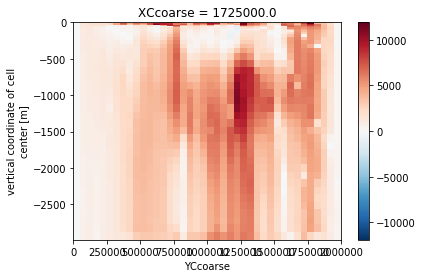

In [774]:
Ktensor_3.sel(XCcoarse=1700e3, method='nearest').isel(i=1, j=1).plot()

In [770]:
# this does the same thing as the old calc tensor; solves stacked problem,
# but does weighting but the amount of flux.
def calc_tensor_3(uc,vc,wc, cx,cy,cz):
    Afluxu = np.array([uc]).T
    Afluxv = np.array([vc]).T
    Afluxw = np.array([wc]).T
    
    Wu = np.abs(Afluxu)
    Wv = np.abs(Afluxv)
    Ww = np.abs(Afluxw)
    
    Agrad = np.array([cx, cy, cz]).T

    if ~(np.isnan(Agrad).any() |  np.isnan(1/Wu).any() |  np.isnan(1/Wv).any() |  np.isnan(1/Ww).any() | 
         np.isinf(Agrad).any() |  np.isinf(1/Wu).any() |  np.isinf(1/Wv).any() |  np.isinf(1/Ww).any()):
        
        Kx = pinv(-Agrad/Wu).dot(Afluxu/Wu)
        Ky = pinv(-Agrad/Wv).dot(Afluxv/Wv)
        Kz = pinv(-Agrad/Ww).dot(Afluxw/Ww)
    
        K = np.concatenate((Kx.T, Ky.T, Kz.T), axis=0)
        
        # return(K, Kx)
        return K
    else:
        return np.NaN*np.ones((3,3), dtype='float32')

In [762]:
uc = UpCp.sel(YCcoarse=0, Z=-3000, method='nearest').sel(tracer_num=slice(1,19,2))
vc = VpCp.sel(YCcoarse=0, Z=-3000, method='nearest').sel(tracer_num=slice(1,19,2))
wc = WpCp.sel(YCcoarse=0, Z=-3000, method='nearest').sel(tracer_num=slice(1,19,2))
cx = dCdx.sel(YCcoarse=0, Z=-3000, method='nearest').sel(tracer_num=slice(1,19,2))
cy = dCdy.sel(YCcoarse=0, Z=-3000, method='nearest').sel(tracer_num=slice(1,19,2))
cz = dCdz.sel(YCcoarse=0, Z=-3000, method='nearest').sel(tracer_num=slice(1,19,2))

In [ ]:
Afluxu = np.array([uc]).T
Afluxv = np.array([vc]).T
Afluxw = np.array([wc]).T

Wu = np.abs(Afluxu)
Wv = np.abs(Afluxv)
Ww = np.abs(Afluxw)

Agrad = np.array([cx, cy, cz]).T

if ~(np.isnan(Agrad).any() |  np.isnan(1/Wu).any() |  np.isnan(1/Wv).any() |  np.isnan(1/Ww).any() | 
     np.isinf(Agrad).any() |  np.isinf(1/Wu).any() |  np.isinf(1/Wv).any() |  np.isinf(1/Ww).any()):

    Kx = pinv(-Agrad/Wu).dot(Afluxu/Wu)
    Ky = pinv(-Agrad/Wv).dot(Afluxv/Wv)
    Kz = pinv(-Agrad/Ww).dot(Afluxw/Ww)

    K = np.concatenate((Kx.T, Ky.T, Kz.T), axis=0)